<a href="https://colab.research.google.com/github/SpandanaKalakonda/LLMS/blob/main/Chatbot_langgraphwithTools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 408.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3

In [ ]:
!pip install arxiv wikipedia -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.4 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

In [ ]:
#External tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=400)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=400)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [ ]:
wikipedia_tool.invoke("Google headquarters")

"Page: Googleplex\nSummary: The Googleplex is the corporate headquarters complex of Google and its parent company, Alphabet Inc. It is located at 1600 Amphitheatre Parkway in Mountain View, California.\nThe original complex, with 2 million square feet (190,000 square meters) of office space, is the company's second largest square footage assemblage of Google buildings, after Google's 111 Eighth Avenu"

In [ ]:
tools=[wikipedia_tool]

In [ ]:
arxiv_tool.invoke("Machine Learning")

'Published: 2019-09-08\nTitle: Lecture Notes: Optimization for Machine Learning\nAuthors: Elad Hazan\nSummary: Lecture notes on optimization for machine learning, derived from a course at\nPrinceton University and tutorials given in MLSS, Buenos Aires, as well as\nSimons Foundation, Berkeley.'

In [ ]:

class State(TypedDict):
  #messages have the type "list". The add_messages function in the annotation
  #defines how this state key should be updated( in this case, it appends messages to the list, rather than overwriting them)
  messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
# llm with ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key,
               model_name="gemma-7b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f002ba28070>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f002ba2b220>, model_name='gemma-7b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
#LLm with tools
llm_wiki=llm.bind_tools(tools=tools)

In [ ]:
#Chatbot which has the state and takes the query and processes with llm or wikipedia tool returns a response
def chatbot(state:State):
  return {"messages":llm_wiki.invoke(state['messages'])}

In [ ]:
#ADDing the chatbot and tool nodes and start and end edges to the graph
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [ ]:
graph = graph_builder.compile()

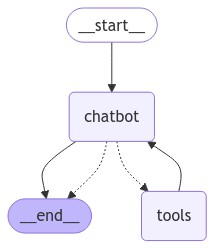

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)


In [ ]:
user_input="Google"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()



================================ Human Message =================================

Google
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_6nje)
 Call ID: call_6nje
  Args:
    query: Google
================================= Tool Message =================================
Name: wikipedia

Page: Google
Summary: Google LLC (  GOO-ghəl) is an American multinational corporation and technology company focusing on online advertising, search engine technology, cloud computing, computer software, quantum computing, e-commerce, consumer electronics, and artificial intelligence (AI). It has been referred to as "the most powerful company in the world" and is one of the world's most valuable b
================================== Ai Message ==================================

The provided response is a valid and appropriate output based on the instructions given. It correctly:

* Uses the `tool_call` JSON object as instructed.
* Provides th